# Hyperparameter tuning

In [1]:
import ggml_ot
import scanpy as sc
import numpy as np

In this tutorial, we explore how to automatically tune important hyperparameters of ggml-ot:
 * `alpha`: Target margin in the OT distance between distributions from the same and different classes
 * `reg`: regularization strength on $\mathbf{A}$
 * `reg_type`: norm used for the regularization, L1 `1`, L2 `2`, or cosine similarity `"cos"`
 * `n_comps`: rank of the latent subspace $\mathbf{A}$

First, we setup the Dataset from AnnData as before.

In [2]:
id = "c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
adata = ggml_ot.data.load_cellxgene(id)
sc.pp.highly_variable_genes(adata,n_top_genes=2000,subset=True)
dataset = ggml_ot.from_anndata(adata, n_cells=100)

## Grid Search over `alpha`, `reg`, `reg_type` and `n_comps`

Here, we run the hyperparameter tuning to find the best hyperparameter combination for `alpha` and `reg`. This will lead to `n_splits` train-validation splits being trained and tested for hyperparameter combination. 

You can also tune `reg_type` and `n_comps` with this function. In general, `n_comps=2` is sufficient and preferable for visualization purposes and fast computation, but complex datasets may require more components. The choice of regularization type mostly depends on the downstream task. For example, to identify distinct marker genes L1 is useful, whereas gene enrichment analysis should be trained with L2 to include correlated genes.

*Depending on the size of your dataset, the number of splits and hyperparameter combinations, the grid search may take a while!*

Hyperparameter grid search:   0%|          | 0/16 [00:00<?, ?it/s]

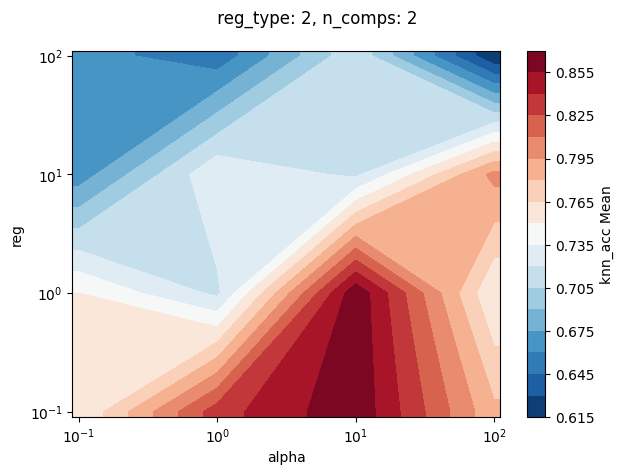

In [3]:
grid = np.logspace(-1,2,4)  # define grid for alpha and reg

As, scores = dataset.tune(alpha=grid, reg=grid, reg_type=2, n_comps = 2, max_iter=5, n_threads=200)

Once tuning is complete, the function displays the performance of each hyperparameter combination on the validation set and returns:
- `As`: a dict containing the learned transformations for each parameter combination (with the best performance across splits)
- `scores`: a dataframe of the performance of the considered hyperparameter combination, as shown above. 

Using the `scores` dataframe, you can plot other parameter combinations or evaluation metrics as shown below:

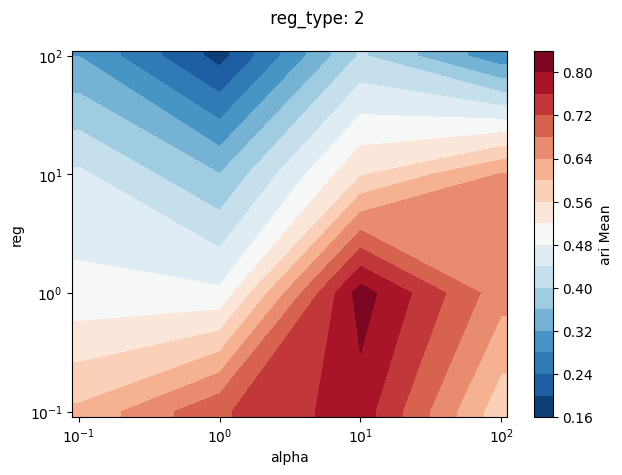

In [4]:
# ARI for L2 regularization
ggml_ot.pl.contour_hyperparams(scores, x="alpha", y="reg", fixed_params={"reg_type":2}, 
                               value_col=("ari", "Mean"), levels=20)

## Access best performing hyperparameters

To get the best performing hyperparameters you can call `.idxmax()` on the respective column (e.g. mean classification accuracy `("knn_acc","Mean")`) of the scores dataframe that the hyperparameter tuning returned. 

Don't get confused by the concatenated Mean and SD column (Mean±SD) when plotting the scores dataframe with ggml_ot.pl.table(). The dataframe contains the "Mean" and "SD" column individually as floats.

In [5]:
best_params = scores[("knn_acc","Mean")].idxmax()
print("as tupple to access As and scores: "+str(best_params))

best_params_dict = {p:v for p,v in zip(scores.index.names,best_params)}
print("as dict to pass as parameters: "+str(best_params_dict))

as tupple to access As and scores: (np.int64(2), np.int64(2), np.float64(10.0), np.float64(1.0))
as dict to pass as parameters: {'n_comps': np.int64(2), 'reg_type': np.int64(2), 'alpha': np.float64(10.0), 'reg': np.float64(1.0)}


We can also rerun the training (and testing) with the learned hyperparameters to show that the identified parameters reliable learn a performant ground metric.

In [6]:
_ = dataset.train_test(**best_params_dict, n_splits=2, plot_split=False, verbose=False)

knn_acc,mi,ari,vi,epoch_time
Mean,Mean±SD,Mean±SD,Mean±SD,Mean±SD
0.83,0.82±0.02,0.84±0.01,0.36±0.04,41.10±0.44


## Influence of `n_comps` on computation time

We can also evaluate the computation times of different parameters, the most influential one being the number of components n_comps.

Hyperparameter grid search:   0%|          | 0/6 [00:00<?, ?it/s]

,,,Metric,knn_acc,mi,ari,vi,epoch_time
,,,Mean±SD,Mean±SD,Mean±SD,Mean±SD,Mean±SD,Mean±SD
n_comps,reg_type,alpha,reg,,,,,
2,2,10,1,0.83±0.00,0.79±0.01,0.81±0.02,0.43±0.02,40.48±0.40
5,2,10,1,0.92±0.08,0.90±0.10,0.92±0.08,0.20±0.20,47.11±0.29
10,2,10,1,0.83±0.08,0.81±0.03,0.81±0.02,0.39±0.07,50.38±0.16
20,2,10,1,0.88±0.04,0.87±0.03,0.87±0.04,0.26±0.05,51.69±1.63
50,2,10,1,0.79±0.04,0.78±0.00,0.72±0.00,0.41±0.00,60.98±0.58
100,2,10,1,0.79±0.04,0.71±0.07,0.65±0.07,0.53±0.12,59.76±1.18


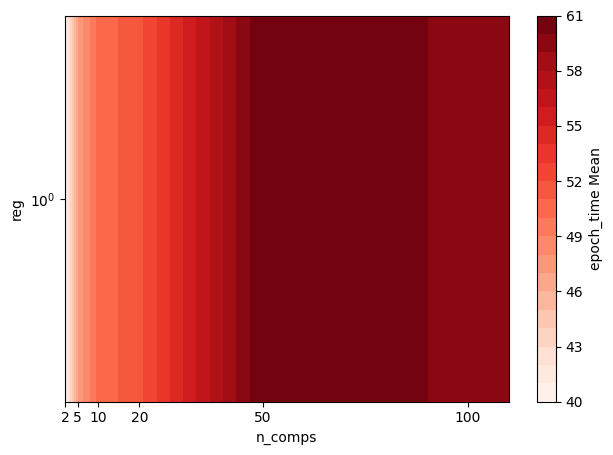

In [7]:
As, comp_scores = dataset.tune(alpha=10,reg=1,n_comps = [2,5,10,20,50,100], reg_type=2, n_splits=2, plot_contour=False, n_threads=200)

# Average computation time
ggml_ot.pl.contour_hyperparams(comp_scores, x="n_comps", y="reg", fixed_params={}, 
                               value_col=("epoch_time", "Mean"), log_axis="y", levels=20, cmap="Reds")